Unsupervised Learning - Dimensionality Reduction

# In Depth: Principal Component Analysis

Up until now, we have been looking in depth at supervised learning estimators: those estimators that predict labels based on labeled training data. Here we begin looking at several unsupervised estimators, which can highlight interesting aspects of the data without reference to any known labels.

In this section, we explore what is perhaps one of the most broadly used of unsupervised algorithms, principal component analsysis (PCA). PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engneering, and much more. After a brief conceptual discussion of the PCA algorithm, we will see a couple examples of these further applications. We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Introduction Principal Component Analysis

Principal component analysis is a fast and flexible unsupervised method for **dimensionality reduction** in data. Its behavior is easiest to visualize by looking at a two-dimensional dataset. Consider the following 200 points:

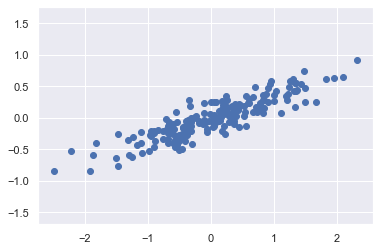

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

By eye, it is clear that there is a nearly linear relationship between the x and y variables. This reminiscent of the linear regression data we explored before, but the problem setting here is slightly different: rather than attempting to **predict** the y values from the x values, the unsupervised learning problem attempts to learn about the relationship beteen the x and y vales.

In principal component analysis, one quantifies thsi relationship by finding a list of the **principal axes** in the data, and using those axes to desribe the dataset. Using Scikit-Learn's `PCA` estimator, we can compute this as follows:

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

The fit learns some quantities for the data, most importantly the "components" and "explained variance":

In [4]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [5]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


To see what these numbers mean, let's visualize them as vectors over the uinput data, using the "components" to define the driecton of th vector, and the "explained variance" to define the squared-length of the vector:

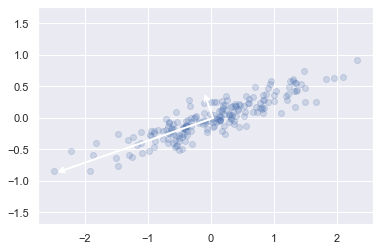

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the **principal axes** of the data, and the length show in the figure above is an indication of how **important** that axis is in describing the distribution of the data - more precisely, it is a measure of the variance of the data when projected onto that axis. The projection of each data point onto the principal axes are the **principal components** of the data. 

If we plot these principal components beside the original data, we see the plots shown below:

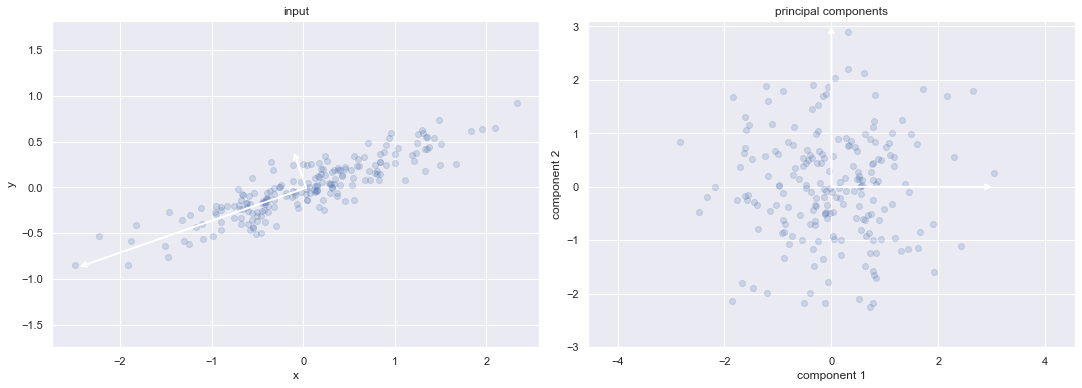

In [8]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
pca = PCA(n_components=2, whiten=True)
pca.fit(X)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# plot data
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
ax[0].axis('equal');
ax[0].set(xlabel='x', ylabel='y', title='input')

# plot principal components
X_pca = pca.transform(X)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
draw_vector([0, 0], [0, 3], ax=ax[1])
draw_vector([0, 0], [3, 0], ax=ax[1])
ax[1].axis('equal')
ax[1].set(xlabel='component 1', ylabel='component 2',
          title='principal components',
          xlim=(-5, 5), ylim=(-3, 3.1))

fig.savefig('figures/05.09-PCA-rotation.png')

This transformtion from data axes to principal axes is an **affine transformation** which basically means it is composed of a translation, roration, and uniform scaling. 

Which this alrorithm to find principal components may seem like just a mathematical curiosity, it turns out to have very far.reaching applications in the world of machine learning and data exploration.

### PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionalty reduction transform:

In [9]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension. To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduction and plot it along with the original data:

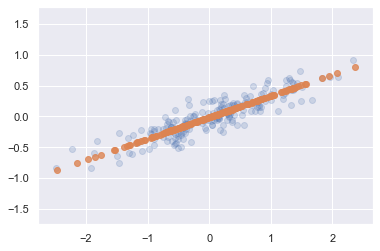

In [10]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version. This makes clear what a PCA dimensionality reduction means: the information along the least important axis or axes is removed, leaving only the component(s) of the data with the highest variance. The fraction of variance that is cut out (proportional to the spread of the points about the line formed in the figure above) is roughly a measure of how much "information" in discarded in this reduction of dimensionality. 

This reducted-dimension dataset is in some sence "good enough" to encode the most important relationship between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points is mostly preserved.

### PCA for visualization: Handwritten digits

The usefulness of the dimensionality reduction may not be entirely appartent in only two dimensions, but becomes much more clear when we look at high-dimensional data. To see this, let's take a quick look at the application of PCA to the digits we saw in the decision trees section.

We start by loading the data:

In [14]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Recall that the data consists of 8x8 pixel images, maning that they are 64-dimensional. To gain some intuition into the relationship between these points, we can use PCA to project them to a manageable number of dimensions, say two:

In [15]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


We can now plot the first two principal components of each point to learn about the data:

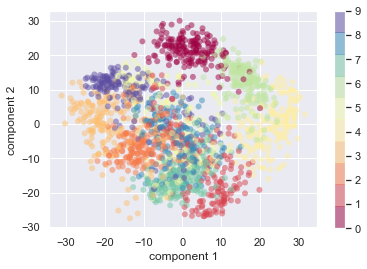

In [17]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Recall what these components mean: the full data is a 64-dimensional point cloud and these points are the projection of each data point along the directions with the largest variance. Essentially, we have found the optimal stretch and rotation in the 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner - that is, without reference to the labels.

### What do the components mean?

We can go a bit further here, and begin to ask what the reduced dimensions **mean**. This menaing can be understoon in terms of combinations of basis vectors. For example, each image in the training set is defined by a collection of 64 pixel values, which we will call the vectore x:

$x = [x_1,x_2,x_3,\dots x_{64}]$

One way we can think about this is in terms of a pixel basis. That is, to construct the image, we multiply each element of the vector by the pixel it describes, and then add the results together to build the image:

$\text{image}(x)=x_1\cdot (\text{pixel}~1) + x_2\cdot (\text{pixel}~2) +x_3\cdot (\text{pixel}~3)\dots x_{64}\cdot (\text{pixel}~64)$

One way we might image reductiuon the dimensions of this data is to zero out all but a few of these basis vectors. For example, if we use only the first eight pixels, we get an eight-dimensional projection of the data, but it is not very reflective of the whole image: we've thrown out nearly 90% of the pixels!

In [18]:
def plot_pca_components(x, coefficients=None, mean=0, components=None,
                        imshape=(8, 8), n_components=8, fontsize=12,
                        show_mean=True):
    if coefficients is None:
        coefficients = x
        
    if components is None:
        components = np.eye(len(coefficients), len(x))
        
    mean = np.zeros_like(x) + mean
        

    fig = plt.figure(figsize=(1.2 * (5 + n_components), 1.2 * 2))
    g = plt.GridSpec(2, 4 + bool(show_mean) + n_components, hspace=0.3)

    def show(i, j, x, title=None):
        ax = fig.add_subplot(g[i, j], xticks=[], yticks=[])
        ax.imshow(x.reshape(imshape), interpolation='nearest')
        if title:
            ax.set_title(title, fontsize=fontsize)

    show(slice(2), slice(2), x, "True")
    
    approx = mean.copy()
    
    counter = 2
    if show_mean:
        show(0, 2, np.zeros_like(x) + mean, r'$\mu$')
        show(1, 2, approx, r'$1 \cdot \mu$')
        counter += 1

    for i in range(n_components):
        approx = approx + coefficients[i] * components[i]
        show(0, i + counter, components[i], r'$c_{0}$'.format(i + 1))
        show(1, i + counter, approx,
             r"${0:.2f} \cdot c_{1}$".format(coefficients[i], i + 1))
        if show_mean or i > 0:
            plt.gca().text(0, 1.05, '$+$', ha='right', va='bottom',
                           transform=plt.gca().transAxes, fontsize=fontsize)

    show(slice(2), slice(-2, None), approx, "Approx")
    return fig

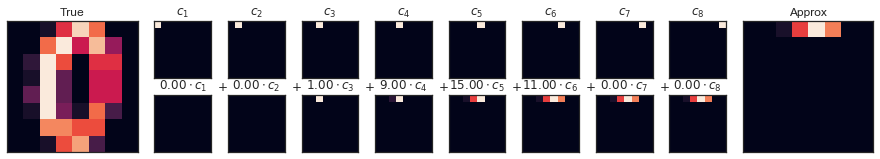

In [20]:
from sklearn.datasets import load_digits

digits = load_digits()
sns.set_style('white')

fig = plot_pca_components(digits.data[10],
                          show_mean=False)

fig.savefig('figures/05.09-digits-pixel-components.png')

The upper row of the panels shows the individual pixels, and the lower row shows the cumulative contribution of these pixels to the construction of the image. Using only eight of the pixel-basis components, we can only construct a small portion of the 64-pixel image. were we to continue this sequence and use all 64 pixels, we would recover the original image.

But the pixel-wise representation is not the only choice of basis. We can also use other basis functions, hwich each contain some predefined contribution from each pixel, and write something like:

$\text{image}(x)=\text{mean} + x_1\cdot (\text{basis}~1) + x_2\cdot (\text{basis}~2) +x_3\cdot (\text{basis}~3)\dots$

PCA can be thought of as a process of 

### Choosing the number of components

## PCA as Noise Filtering

## Example: Eigenfaces

## Principal Component Analaysis Summary